# AKARI-NEP master catalogue
## Checks and diagnostics

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
04829ed (Thu Nov 2 16:57:19 2017 +0000) [with local modifications]


In [4]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
plt.style.use('ggplot')

import locale
locale.setlocale(locale.LC_ALL, 'en_GB')

import os
import time
import itertools

from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy import units as u
from astropy import visualization as vis
import numpy as np
from matplotlib_venn import venn3, venn2

from herschelhelp_internal.masterlist import nb_compare_mags, nb_ccplots, nb_histograms, find_last_ml_suffix

In [5]:
OUT_DIR = os.environ.get('OUT_DIR', "./data")
SUFFIX = find_last_ml_suffix()
#SUFFIX = "20171016"

master_catalogue_filename = "master_catalogue_akari-nep_{}.fits".format(SUFFIX)
master_catalogue = Table.read("{}/{}".format(OUT_DIR, master_catalogue_filename))

print("Diagnostics done using: {}".format(master_catalogue_filename))

Diagnostics done using: master_catalogue_akari-nep_20171107.fits


## I - Summary of wavelength domains

In [6]:
flag_obs = master_catalogue['flag_optnir_obs']
flag_det = master_catalogue['flag_optnir_det']

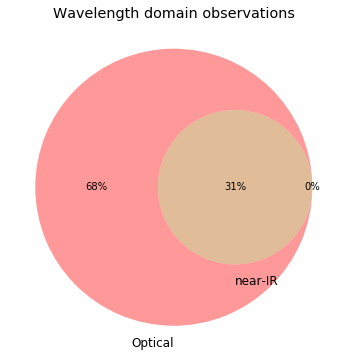

In [7]:
venn2(
    [
        np.sum(flag_obs == 1),
        np.sum(flag_obs == 2),
        np.sum(flag_obs == 3)
    ],
    set_labels=('Optical', 'near-IR'),
    subset_label_formatter=lambda x: "{}%".format(int(100*x/len(flag_obs)))
)
plt.title("Wavelength domain observations");

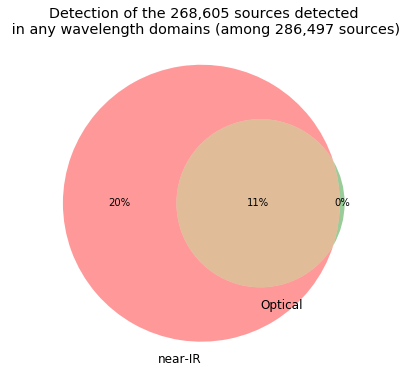

In [8]:
venn2(
    [
        np.sum(flag_det[flag_obs == 3] == 1),
        np.sum(flag_det[flag_obs == 3] == 2),
        np.sum(flag_det[flag_obs == 3] == 3)
    ],
    set_labels=('near-IR', 'Optical'),
    subset_label_formatter=lambda x: "{}%".format(int(100*x/np.sum(flag_det != 0)))
)
plt.title("Detection of the {} sources detected\n in any wavelength domains "
          "(among {} sources)".format(
              locale.format('%d', np.sum(flag_det != 0), grouping=True),
              locale.format('%d', len(flag_det), grouping=True)));

## II - Comparing magnitudes in similar filters

The master list if composed of several catalogues containing magnitudes in similar filters on different instruments. We are comparing the magnitudes in these corresponding filters.

In [9]:
u_bands = ["Megacam u"]
g_bands = ["Megacam g", "GPC1 g"]
r_bands = ["Megacam r", "GPC1 r"]
i_bands = ["Megacam i", "GPC1 i"]
z_bands = ["Megacam z", "GPC1 z"]
y_bands = [             "GPC1 y", "Wircam y"]
j_bands = [                       "Wircam j"]
k_bands = [                       "Wircam k"]

### II.a - Comparing depths

We compare the histograms of the total aperture magnitudes of similar bands.

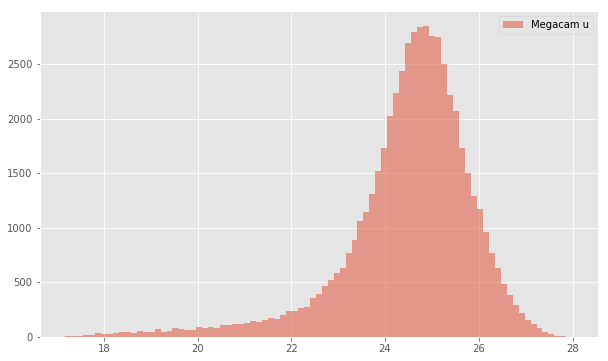

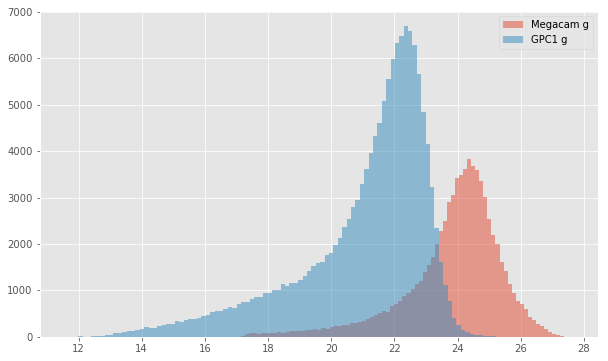

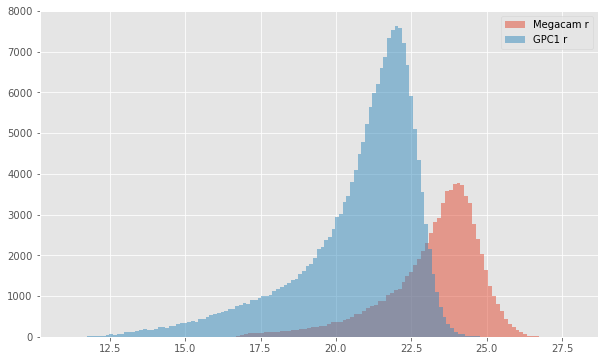

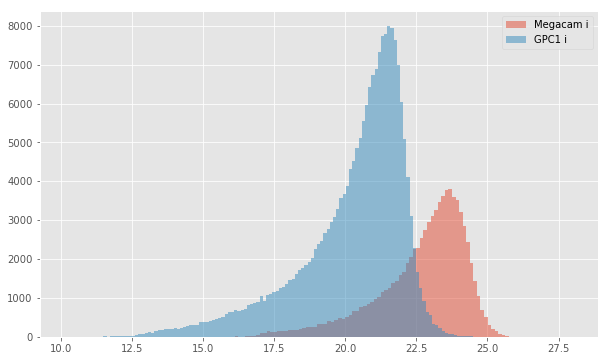

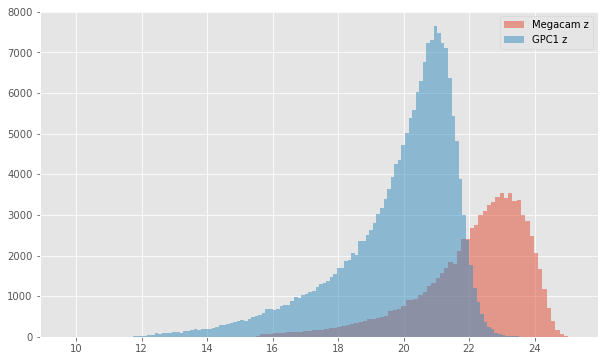

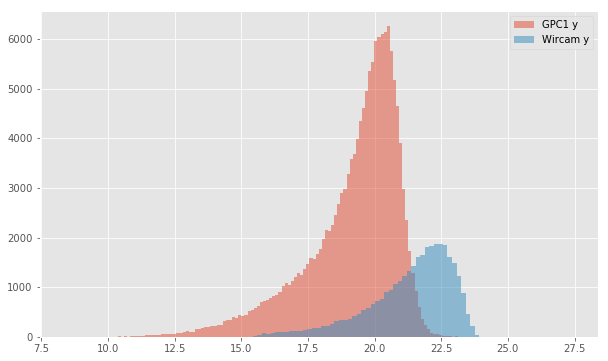

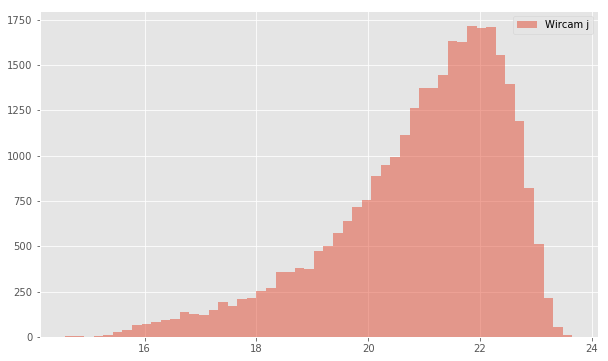

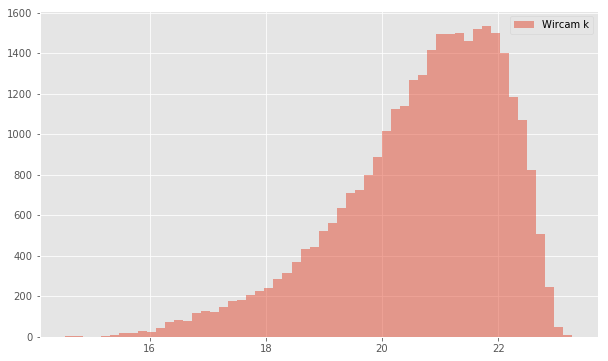

In [10]:
for bands in [u_bands, g_bands, r_bands, i_bands, z_bands, y_bands, j_bands, k_bands]:
    colnames = ["m_{}".format(band.replace(" ", "_").lower()) for band in bands]
    nb_histograms(master_catalogue, colnames, bands)

### II.b - Comparing magnitudes

We compare one to one each magnitude in similar bands.

No sources have both Megacam g (aperture) and GPC1 g (aperture) values.
GPC1 g (total) - Megacam g (total):
- Median: 0.09
- Median Absolute Deviation: 0.12
- 1% percentile: -1.1177866744995117
- 99% percentile: 0.9651809883117686


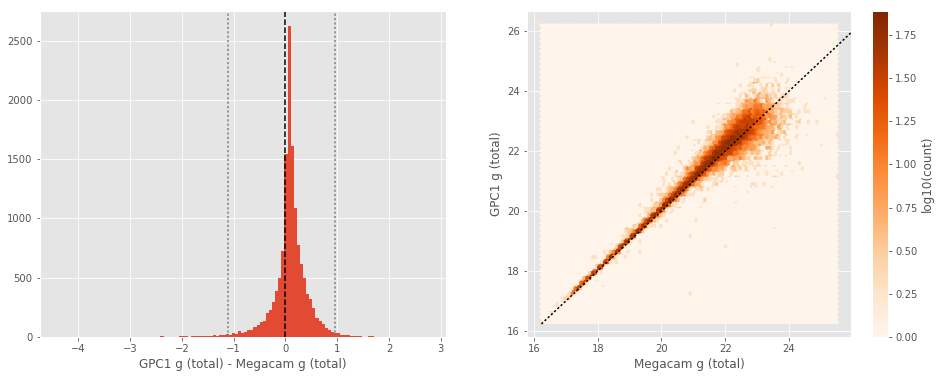

No sources have both Megacam r (aperture) and GPC1 r (aperture) values.
GPC1 r (total) - Megacam r (total):
- Median: 0.07
- Median Absolute Deviation: 0.09
- 1% percentile: -0.5968659400939942
- 99% percentile: 0.844063377380373


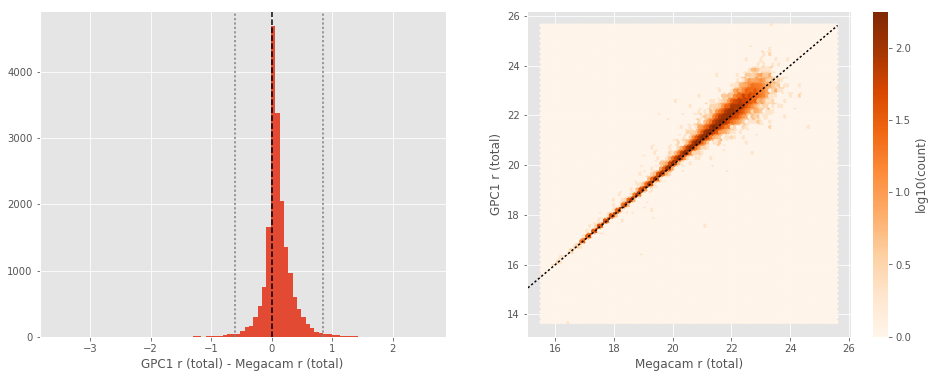

No sources have both Megacam i (aperture) and GPC1 i (aperture) values.
GPC1 i (total) - Megacam i (total):
- Median: 0.06
- Median Absolute Deviation: 0.07
- 1% percentile: -0.524024486541748
- 99% percentile: 0.6067495346069336


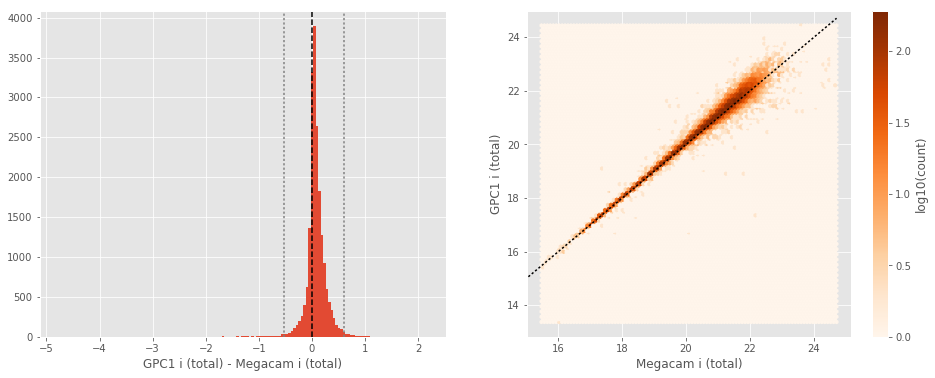

No sources have both Megacam z (aperture) and GPC1 z (aperture) values.
GPC1 z (total) - Megacam z (total):
- Median: 0.25
- Median Absolute Deviation: 0.09
- 1% percentile: -0.32895492553710937
- 99% percentile: 0.9741711425781265


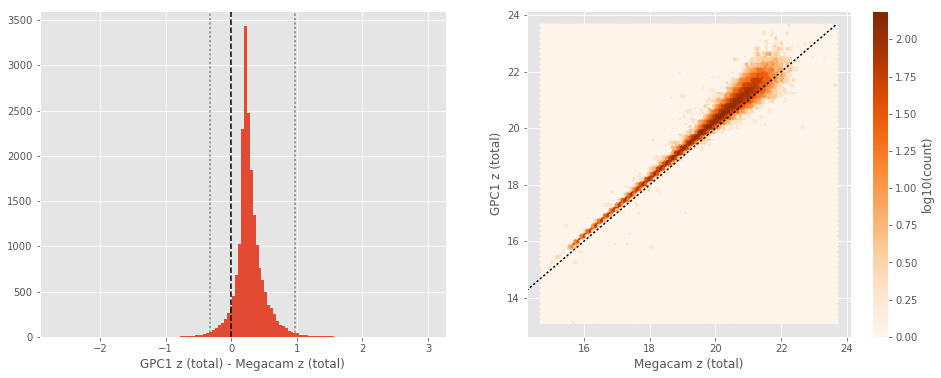

No sources have both GPC1 y (aperture) and Wircam y (aperture) values.
Wircam y (total) - GPC1 y (total):
- Median: -0.20
- Median Absolute Deviation: 0.14
- 1% percentile: -1.075844135284424
- 99% percentile: 0.7053063774108901


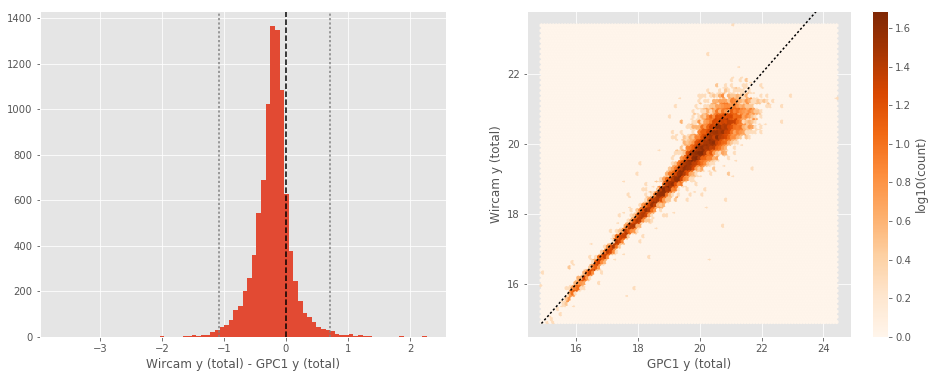

In [11]:
for band_of_a_kind in [u_bands, g_bands, r_bands, i_bands, z_bands, y_bands]:
    for band1, band2 in itertools.combinations(band_of_a_kind, 2):
        
        basecol1, basecol2 = band1.replace(" ", "_").lower(), band2.replace(" ", "_").lower()
        
        col1, col2 = "m_ap_{}".format(basecol1), "m_ap_{}".format(basecol2)
        nb_compare_mags(master_catalogue[col1], master_catalogue[col2], 
                        labels=("{} (aperture)".format(band1), "{} (aperture)".format(band2)))
        
        col1, col2 = "m_{}".format(basecol1), "m_{}".format(basecol2)
        nb_compare_mags(master_catalogue[col1], master_catalogue[col2], 
                        labels=("{} (total)".format(band1), "{} (total)".format(band2)))

## III - Comparing magnitudes to reference bands

Cross-match the master list to SDSS and 2MASS to compare its magnitudes to SDSS and 2MASS ones.

In [12]:
master_catalogue_coords = SkyCoord(master_catalogue['ra'], master_catalogue['dec'])

### III.a - Comparing u, g, r, i, and z bands to SDSS

The catalogue is cross-matched to SDSS-DR13 withing 0.2 arcsecond. 

We compare the u, g, r, i, and z magnitudes to those from SDSS using `fiberMag` for the aperture magnitude and `petroMag`  for the total magnitude.

In [13]:
sdss = Table.read("../../dmu0/dmu0_SDSS-DR13/data/SDSS-DR13_AKARI-NEP.fits")
sdss_coords = SkyCoord(sdss['ra'] * u.deg, sdss['dec'] * u.deg)

idx, d2d, _ = sdss_coords.match_to_catalog_sky(master_catalogue_coords)
mask = (d2d < 0.2 * u.arcsec)

sdss = sdss[mask]
ml_sdss_idx = idx[mask]

No sources have both SDSS u (petroMag) and Megacam u (total) values.
No sources have both SDSS g (petroMag) and Megacam g (total) values.
GPC1 g (total) - SDSS g (petroMag):
- Median: -0.14
- Median Absolute Deviation: 0.22
- 1% percentile: -3.204806213378906
- 99% percentile: 2.276905021667485


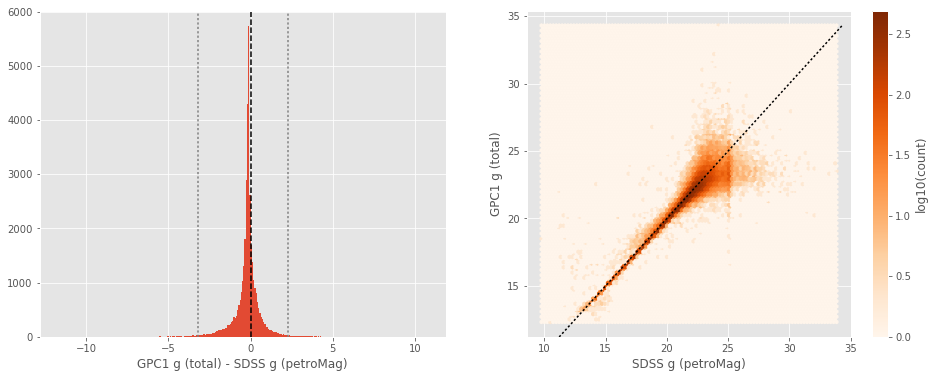

No sources have both SDSS r (petroMag) and Megacam r (total) values.
GPC1 r (total) - SDSS r (petroMag):
- Median: -0.04
- Median Absolute Deviation: 0.12
- 1% percentile: -2.0909242630004883
- 99% percentile: 1.4419375610351597


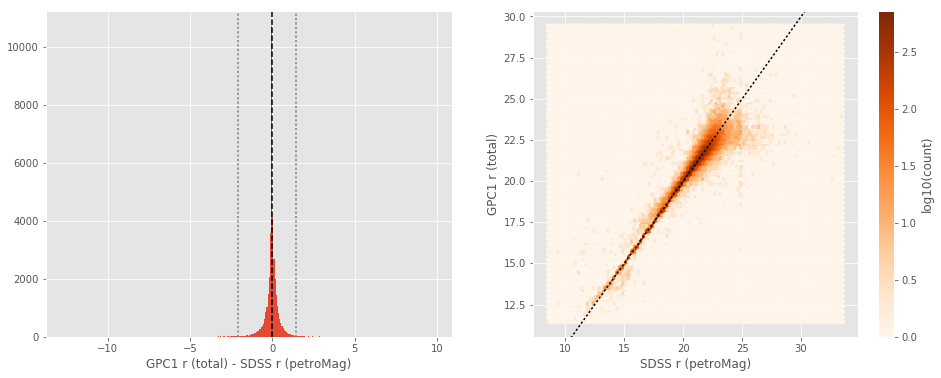

No sources have both SDSS i (petroMag) and Megacam i (total) values.
GPC1 i (total) - SDSS i (petroMag):
- Median: -0.04
- Median Absolute Deviation: 0.09
- 1% percentile: -2.318520050048828
- 99% percentile: 0.9392152404785161


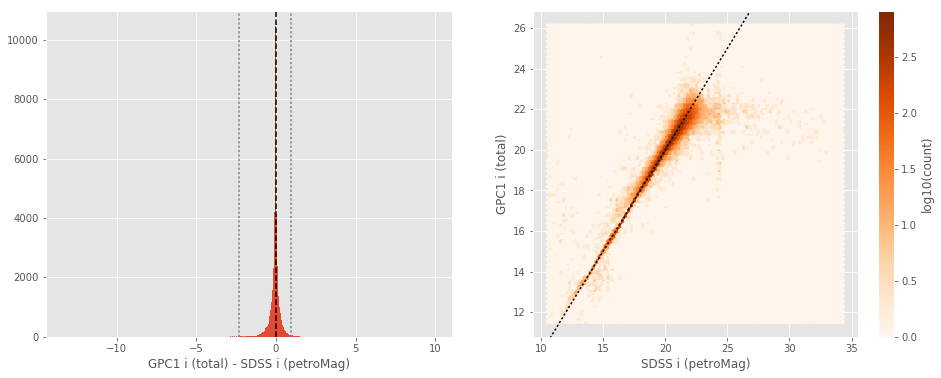

No sources have both SDSS z (petroMag) and Megacam z (total) values.
GPC1 z (total) - SDSS z (petroMag):
- Median: 0.02
- Median Absolute Deviation: 0.19
- 1% percentile: -3.1349078750610353
- 99% percentile: 1.6863268470764128


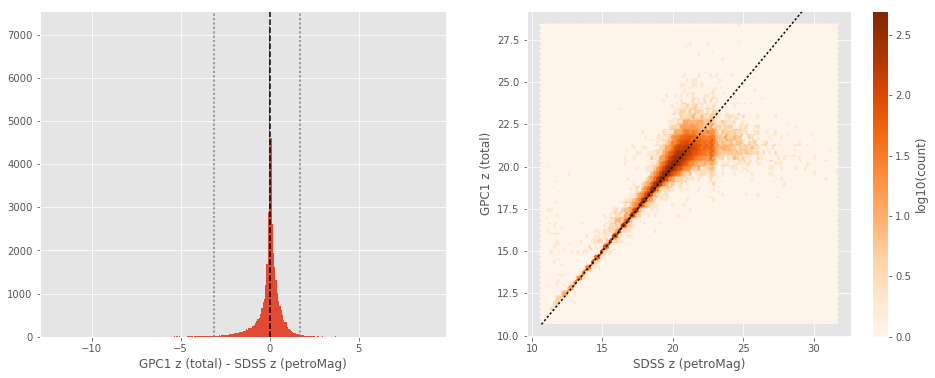

In [15]:
for band_of_a_kind in [u_bands, g_bands, r_bands, i_bands, z_bands]:
    for band in band_of_a_kind:
        
    
        sdss_mag_tot = sdss["petroMag_{}".format(band[-1])]
        master_cat_mag_tot = master_catalogue["m_ap_{}".format(band.replace(" ", "_").lower())][ml_sdss_idx]
        
        nb_compare_mags(sdss_mag_tot, master_cat_mag_tot,
                        labels=("SDSS {} (petroMag)".format(band[-1]), "{} (total)".format(band)))

### III.b - Comparing J and K bands to 2MASS

The catalogue is cross-matched to 2MASS-PSC withing 0.2 arcsecond. We compare the UKIDSS total J and K magnitudes to those from 2MASS.

The 2MASS magnitudes are “*Vega-like*” and we have to convert them to AB magnitudes using the zero points provided on [this page](http://www.ipac.caltech.edu/2mass/releases/allsky/doc/sec6_4a.html):

| Band | Fν - 0 mag (Jy) |
|------|-----------------|
| J    | 1594            |
| H    | 1024            |
| Ks   | 666.7           |

In addition, UKIDSS uses a K band whereas 2MASS uses a Ks (“short”) band, [this page](http://www.ipac.caltech.edu/2mass/releases/allsky/doc/sec6_4b.html) give a correction to convert the K band in a Ks band with the formula:

$$K_{s(2MASS)} = K_{UKIRT} + 0.003 + 0.004 * (J−K)_{UKIRT}$$

In [16]:
# The AB zero point is 3631 Jy
j_2mass_to_ab = 2.5 * np.log10(3631/1595)
k_2mass_to_ab = 2.5 * np.log10(3631/666.7)

In [17]:
twomass = Table.read("../../dmu0/dmu0_2MASS-point-sources/data/2MASS-PSC_AKARI-NEP.fits")
twomass_coords = SkyCoord(twomass['raj2000'], twomass['dej2000'])

idx, d2d, _ = twomass_coords.match_to_catalog_sky(master_catalogue_coords)
mask = (d2d < 0.2 * u.arcsec)

twomass = twomass[mask]
ml_twomass_idx = idx[mask]

WIRCAM J (total) - 2MASS J:
- Median: 0.03
- Median Absolute Deviation: 0.07
- 1% percentile: -0.928474068441564
- 99% percentile: 0.3543059425447635


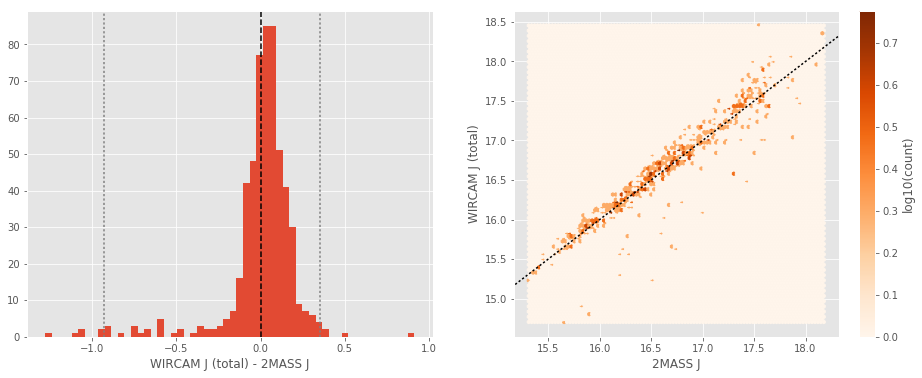

In [18]:
nb_compare_mags(twomass['jmag'] + j_2mass_to_ab, master_catalogue['m_wircam_j'][ml_twomass_idx],
                labels=("2MASS J", "WIRCAM J (total)"))

WIRCAM Ks-like (total) - 2MASS Ks:
- Median: 0.08
- Median Absolute Deviation: 0.14
- 1% percentile: -0.8233416467150252
- 99% percentile: 0.9889085999433009


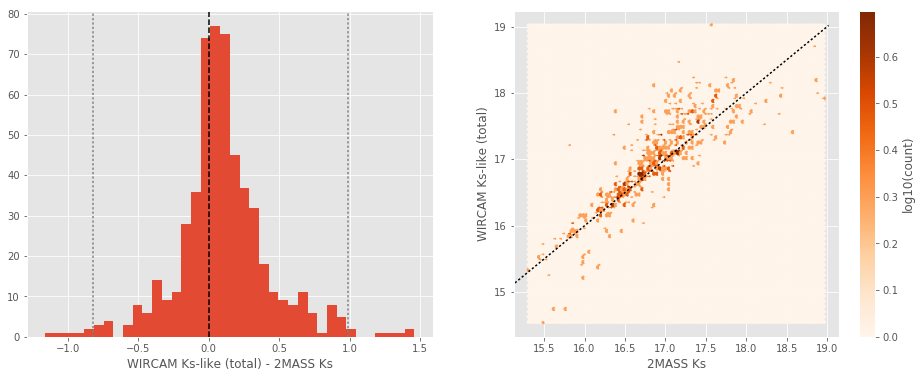

In [19]:
ukidss_ks_like = master_catalogue['m_wircam_k'] + 0.003 + 0.004 * (
    master_catalogue['m_wircam_j'] - master_catalogue['m_wircam_k'])
nb_compare_mags(twomass['kmag'] + k_2mass_to_ab, ukidss_ks_like[ml_twomass_idx],
                labels=("2MASS Ks", "WIRCAM Ks-like (total)"))

## Keeping only sources with good signal to noise ratio

From here, we are only comparing sources with a signal to noise ratio above 3, i.e. roughly we a magnitude error below 0.3.

*To make it easier, we are setting to NaN in the catalogue the magnitudes associated with an error above 0.3 so we can't use these magnitudes after the next cell.*

In [20]:
for error_column in [_ for _ in master_catalogue.colnames if _.startswith('merr_')]:
    column = error_column.replace("merr", "m")
    keep_mask = np.isfinite(master_catalogue[error_column])
    keep_mask[keep_mask] &= master_catalogue[keep_mask][error_column] <= 0.3
    master_catalogue[column][~keep_mask] = np.nan

## IV - Comparing aperture magnitudes to total ones.

Number of source used: 18570 / 286497 (6.48%)


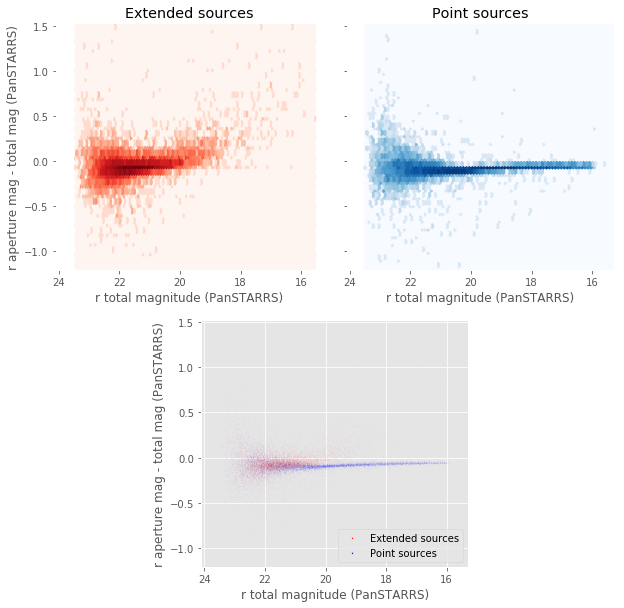

In [21]:
nb_ccplots(
    master_catalogue['m_gpc1_r'],
    master_catalogue['m_ap_gpc1_r'] - master_catalogue['m_gpc1_r'],
    "r total magnitude (PanSTARRS)", "r aperture mag - total mag (PanSTARRS)",
    master_catalogue["stellarity"],
    invert_x=True
)

## V - Color-color and magnitude-color plots

Number of source used: 25036 / 286497 (8.74%)


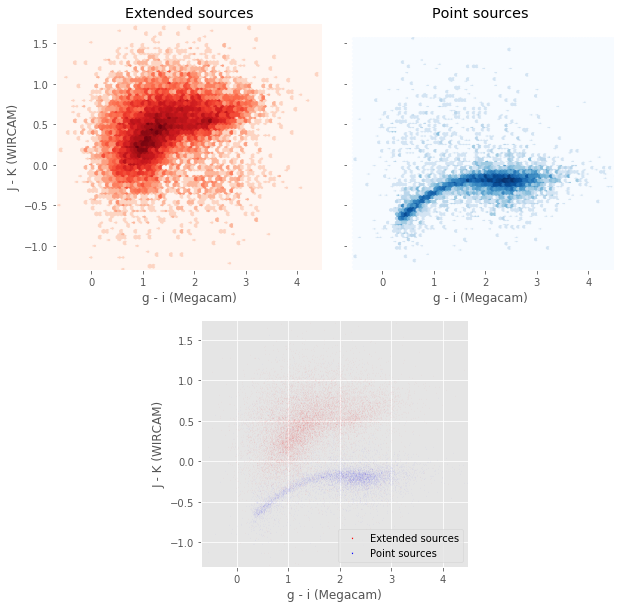

In [22]:
nb_ccplots(
    master_catalogue['m_megacam_g'] - master_catalogue['m_megacam_i'],
    master_catalogue['m_wircam_j'] - master_catalogue['m_wircam_k'],
    "g - i (Megacam)", "J - K (WIRCAM)",
    master_catalogue["stellarity"]
)

Number of source used: 14029 / 286497 (4.90%)


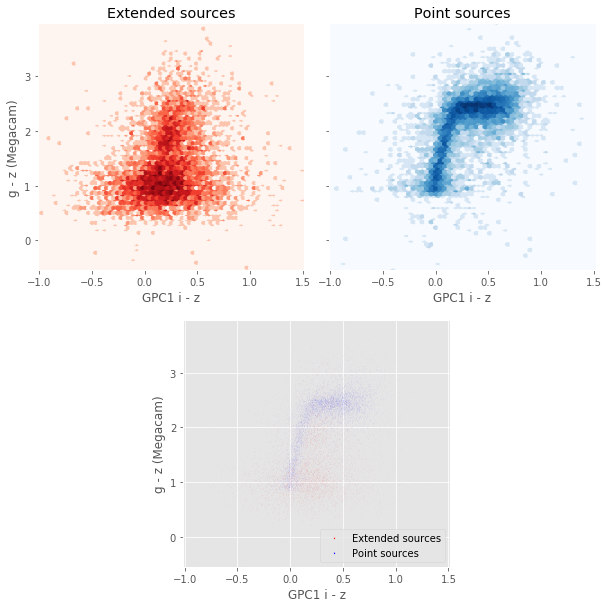

In [26]:
nb_ccplots(
    master_catalogue['m_gpc1_i'] - master_catalogue['m_gpc1_z'],
    master_catalogue['m_megacam_u'] - master_catalogue['m_megacam_g'],
    "GPC1 i - z", "g - z (Megacam)",
    master_catalogue["stellarity"]
)

Number of source used: 52325 / 286497 (18.26%)


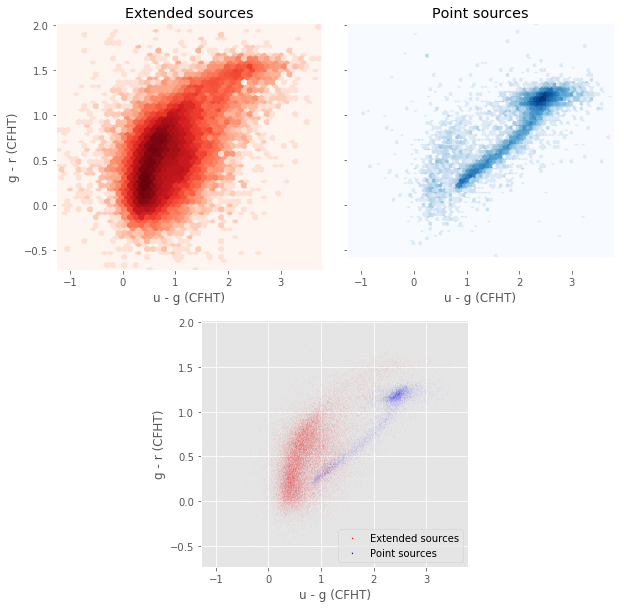

In [27]:
nb_ccplots(
    master_catalogue['m_megacam_u'] - master_catalogue['m_megacam_g'],
    master_catalogue['m_megacam_g'] - master_catalogue['m_megacam_r'],
    "u - g (CFHT)", "g - r (CFHT)",
    master_catalogue["stellarity"]
)

Number of source used: 7998 / 286497 (2.79%)


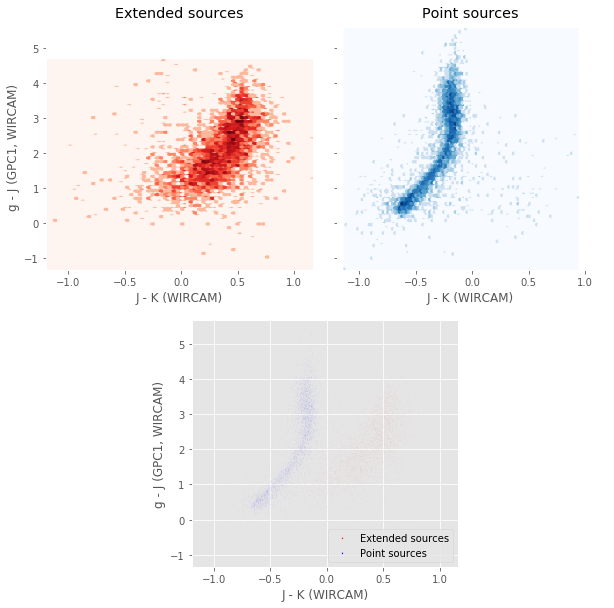

In [28]:
nb_ccplots(
    master_catalogue['m_wircam_j'] - master_catalogue['m_wircam_k'],
    master_catalogue['m_gpc1_g'] - master_catalogue['m_wircam_j'],
    "J - K (WIRCAM)", "g - J (GPC1, WIRCAM)",
    master_catalogue["stellarity"]
)

Number of source used: 11395 / 286497 (3.98%)


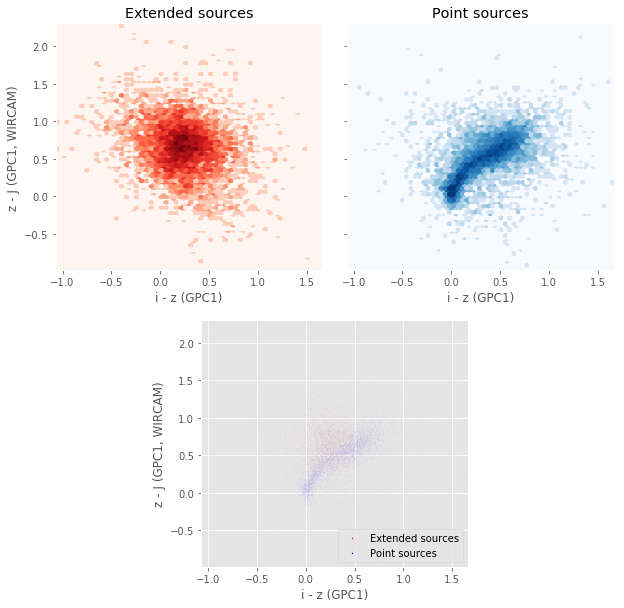

In [29]:
nb_ccplots(
    master_catalogue['m_gpc1_i'] - master_catalogue['m_gpc1_z'],
    master_catalogue['m_gpc1_z'] - master_catalogue['m_wircam_j'],
    "i - z (GPC1)", "z - J (GPC1, WIRCAM)",
    master_catalogue["stellarity"]
)